In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
frame1 = cv2.imread("/kaggle/input/lucas-kanade/Q2-1.png", cv2.IMREAD_GRAYSCALE)
frame2 = cv2.imread("/kaggle/input/lucas-kanade/Q2-2.png", cv2.IMREAD_GRAYSCALE)

In [11]:
sift = cv2.SIFT_create(nfeatures=1000)
keypoints = sift.detect(frame1, None)

In [12]:
def KL(frame1, frame2, window_size, keypoints, min_quality=0.01):
    w = int(window_size/2)
    frame1 = frame1 / 255
    frame2 = frame2 / 255

    mask_x = np.array([[-1, 1], [-1, 1]])
    mask_y = np.array([[-1, -1], [1, 1]])
    mask1_t = np.array([[1, 1], [1, 1]])
#     mask2_t = np.array([[-1, -1], [-1, -1]])

    fx = cv2.filter2D(frame1, -1, mask_x)   
    fy = cv2.filter2D(frame1, -1, mask_y)        
    ft = cv2.filter2D(frame2, -1, mask1_t) - cv2.filter2D(frame1, -1, mask1_t) 

    u = np.zeros(frame1.shape)
    v = np.zeros(frame1.shape)

    for kp in keypoints:
        j, i = int(kp.pt[0]), int(kp.pt[1])
        if i - w < 0 or i + w >= frame1.shape[0] or j - w < 0 or j + w >= frame1.shape[1]:
            continue

        I_x = fx[i - w:i + w + 1, j - w:j + w + 1].flatten()
        I_y = fy[i - w:i + w + 1, j - w:j + w + 1].flatten()
        I_t = ft[i - w:i + w + 1, j - w:j + w + 1].flatten()
        b = np.reshape(I_t, (I_t.shape[0], 1))
        A = np.vstack((I_x, I_y)).T
        U = np.matmul(np.linalg.pinv(A), b)
        u[i, j] = U[0][0]
        v[i, j] = U[1][0]

    return u, v

In [13]:
u, v = KL(frame1, frame2, 3, keypoints, 0.05)

In [14]:
u

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
v

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
def filter(u, v, threshold=0.5):
    magnitude = np.sqrt(u**2 + v**2)
    u[magnitude < threshold] = 0
    v[magnitude < threshold] = 0
    return u, v

u, v = filter(u, v)

In [16]:
displacement = np.ones_like(frame2)
displacement.fill(255.)    

for i in range(frame2.shape[0]):
    for j in range(frame2.shape[1]):
        start_pixel = (i,j)
        end_pixel = ( int(i+u[i][j]), int(j+v[i][j]) )
        x, y = end_pixel
        end_x, end_y = frame1.shape
        if u[i][j] and v[i][j] and 0 <= x and x < end_x and 0 <= y and y < end_y:     
            displacement = cv2.arrowedLine( displacement, start_pixel, end_pixel, (0, 0, 0), thickness = 2)

Text(0.5, 1.0, 'displacements')

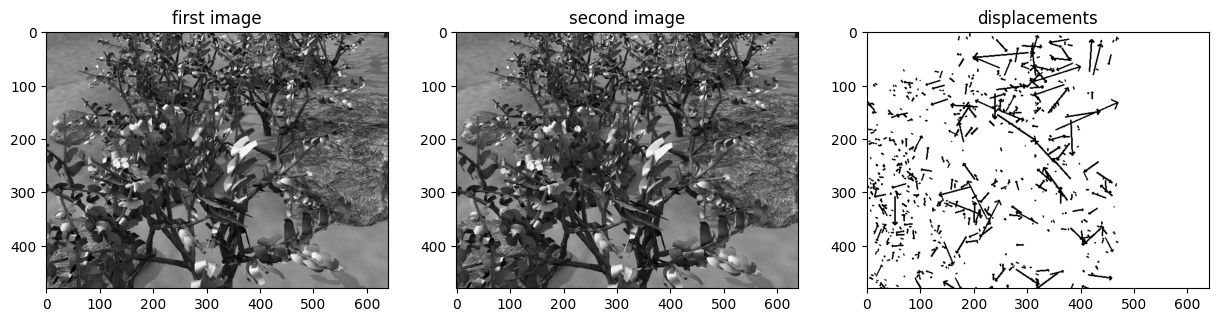

In [17]:
figure, axes = plt.subplots(1,3, figsize=(15, 5))
axes[0].imshow(frame1, cmap = "gray")
axes[0].set_title("first image")
axes[1].imshow(frame2, cmap = "gray")
axes[1].set_title("second image")
axes[2].imshow(displacement, cmap = "gray")
axes[2].set_title("displacements")